In [8]:
import os
import math
import pyloudnorm as pyln
import soundfile as sf
import numpy as np
from preprocessing import *
from equalization import *
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import butter, lfilter, freqz, hilbert
from pysndfx import AudioEffectsChain
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from IPython.core.debugger import set_trace

def normalize(x, peak):
    x_norm = pyln.normalize.peak(x, peak)
    return librosa.to_mono(x_norm.T)

def envelope_detection(x):
    analytic_signal = hilbert(x)
    amplitude_env = np.abs(analytic_signal)
    return amplitude_env

def noise_gate(x, holdtime, ltrhold, utrhold, release, attack, fs):
    rel = round(release * fs)
    att = round(attack * fs)
    g = np.zeros(x.shape)
    lthcnt = 0
    uthcnt = 0
    ht = round(holdtime * fs)
    for n in range(len(x)):
        if (x[n] <= ltrhold) or ((x[n] < utrhold) and (lthcnt>0)):
            lthcnt+=1
            uthcnt = 0
            if lthcnt > ht:
                if lthcnt > (rel + ht):
                    g[n] = 0
                else:
                    g[n] = 1 - ((lthcnt - ht) / rel)
            elif ((n < ht) and (lthcnt==n)):
                g[n] = 0;
            else:
                g[n] = 1;
        elif (x[n] >= utrhold) or ((x[n] > ltrhold) and (uthcnt > 0)):
            uthcnt+=1
            if (g[n-1] < 1):
                g[n] = np.maximum(uthcnt / att, g[n-1])
            else:
                g[n] = 1
            lthcnt = 0
        else:
            g[n] = g[n-1]
            lthcnt = 0
            uthcnt = 0
    return g

def mse(x): return np.sqrt(np.mean(np.abs(x)**2, axis=0))

def ema(x, y, decay): return ((1-decay)*x) + (decay*y)  

def loudness(x, decay):
    N = x.shape[0]
    e_y = np.zeros(2)
    L_m = np.zeros(x.shape)
    sum_x = abs(x[0]**2)
    elems = 1
    mean_x = sum_x / elems
    e_x = math.sqrt(mean_x)
    e_y[0] = (1-decay) * e_x
    e_y[1] = ema(e_x, e_y[0], decay)
    L_m[0] = 0.691 * (10 * math.log10(e_y[1]+1))
    e_y[0] = e_y[1]
    for n in range(1, N):
        sum_x+=abs(x[n]**2)
        elems=n+1
        mean_x = sum_x / elems
        e_x = math.sqrt(mean_x)
        e_y[1] = ema(e_x, e_y[0], decay)
        L_m[n] = 0.691 * (10 * math.log10(e_y[1]+1))
        e_y[0] = e_y[1]
    return L_m
        

# def loudness(x, decay):
#     N = x.shape[0]
#     e_y = np.zeros(2)
#     L_m = np.zeros(x.shape)
#     e_x = np.sqrt(np.abs(x[0])**2)
#     e_y[0] = (1-decay) * e_x
#     e_y[1] = ema(e_x, e_y[0], decay)
#     L_m[0] = 0.691 * (10 * np.log10(e_y[1]))
#     e_y[0] = e_y[1]
#     for n in range(1, N):
#         e_x = mse(x[0:n+1])
#         e_y[1] = ema(e_x, e_y[0], decay)
#         L_m[n] = 0.691 * (10 * np.log10(e_y[1]))
#         e_y[0] = e_y[1]
#     return L_m

def full_loudness(x, decay, step, fs):
    N = x.shape[0]
    num_segments = int(N / (step * fs))
    L_m = np.zeros(x.shape)
    for n in range(num_segments):
        L_m[step*fs*n: step*fs*(n+1)] = loudness(x[step*fs*n: step*fs*(n+1)], decay)
    L_m[step*fs*(n+1):] = loudness(x[step*fs*(n+1):], decay)
    return L_m

def loudness_avg(channels, decay, holdtime, ltrhold, utrhold, release, attack, fs):
    gains = [noise_gate(channels[i], holdtime, ltrhold, utrhold, release, attack, fs) 
             for i in range(len(channels))]
    gains = [np.where(gain < 1, 0, 1) for gain in gains]
    gain_val = np.array(gains).sum(axis=0)
#     print(gain_val)
    L_c = np.array(channels).sum(axis=0)
    L_av = np.where(gain_val > 0, L_c / gain_val, 0)
    # apply ema filter
    return L_av

def compute_gain(gcf, L1, t):
    G_m = np.zeros(L1.shape)
    G_m[0] = 1
    t_active = 0
    for n in range(1, len(G_m)):
        if (L1[n] > -70) and (L1[n] < -20) and (t_active < t):
            G_m[n] = (1 + gcf) * G_m[n-1]
            t_active+=1
        elif L1[n] > -10:
            G_m[n] = (1 - gcf) * G_m[n-1]
        else:
            G_m[n] = G_m[n-1]
            t_active = 0
    return G_m

def compute_fader(L_av, L2):
    F_m = np.zeros(L2.shape)
#     print(F_m.shape)
    for n in range(len(F_m)):
        F_m[n] = 10 ** ((L_av[n] - L2[n]) / 20)
    return F_m

In [3]:
files = full_file_scraper("../Downloads/devon/")

In [55]:
xs = []
for file in files[0:5]:
    x, _ = sf.read(file)
    xs.append(x)
# xs = [sf.read[file] for file in files[0:5]]
x_norms = [normalize(x[0:fs*9+3], 0) for x in xs]
ls = [full_loudness(x_norm[0:fs*9+3], 0.9, 3, 44100) for x_norm in x_norms]

In [54]:
ls[0].shape

(396903,)

In [70]:
l_avg = loudness_avg(ls, 0.85, holdtime=0.05, ltrhold=-30, utrhold=-25, release=0.05, attack=0.01, fs=44100)
# print(l_avg, l_avg.shape)
gains = [compute_gain(0.005, l, 30) for l in ls]

/anaconda3/envs/audio/lib/python3.5/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide


In [71]:
faders = [compute_fader(l_avg, l) for l in ls]
ys = [x_norm * gain * fader for x_norm, gain, fader in zip(x_norms, gains, faders)]

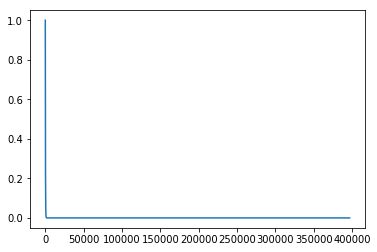

In [89]:
plt.plot(gains[4])

In [83]:
ipd.Audio(x_d, rate=44100)

error: ushort format requires 0 <= number <= (32767 *2 +1)

In [4]:
files[4]

'../Downloads/devon/EQ - Mozzy Type - Bad Guy Kick.wav'

In [82]:
# x, fs = librosa.load("../Downloads/devon/EQ - Mozzy Type - Chromosome_Gm_01.wav")
x_d, fs = sf.read(files[4])
x_norm = normalize(x_d, 0)
# meter = pyln.Meter(fs)
# x, fs = librosa.load("../Downloads/My recording 4.wav", sr=16000)

In [72]:
# x, fs = librosa.load(files[4])

In [6]:
x_norm.shape

(6585600,)

In [11]:
# mse(x_norm[0])

In [21]:
loudness(x_norm[fs*3:fs*6], 0.9)

array([-38.26559735, -37.5432105 , -36.9029978 , ..., -34.33219308,
       -34.33219491, -34.33219768])

In [38]:
%%time 
full_loudness(x_norm[0:fs*9+3], 0.9, 3, fs)

CPU times: user 1.14 s, sys: 6.48 ms, total: 1.15 s
Wall time: 1.18 s


array([8.70058899e-06, 1.24097798e-05, 1.49077413e-05, ...,
       0.00000000e+00, 0.00000000e+00, 2.64383814e-06])

In [61]:
envelope_detection(L), L

(array([41.2246058 , 40.27503739, 39.86023981, ..., 36.43638066,
        36.41994369, 36.68216914]),
 array([-41.00961026, -40.265888  , -39.84724388, ..., -36.36187461,
        -36.36187571, -36.36187872]))

In [44]:
# L[0:1000]

In [19]:
np.mean(L)

-34.331569247316295

In [58]:
g = noise_gate(L, holdtime=0.05, ltrhold=-30, utrhold=-25, release=0.05, attack=0.01, fs=fs)

In [55]:
np.unique(g).shape

(2388,)

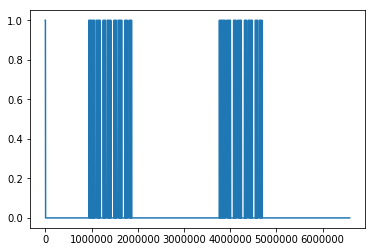

In [47]:
plt.plot(g)

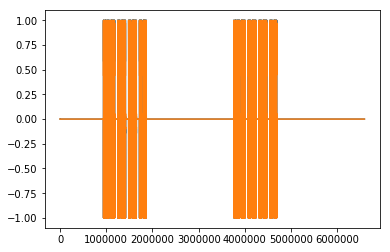

In [20]:
plt.plot(x)

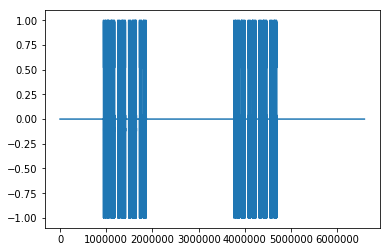

In [21]:
plt.plot(x_norm)

In [8]:
L_av = -70 * np.random.rand(L.shape[0])

In [9]:
np.mean(L_av)

-35.09300444851049

In [20]:
compute_fader(L_av, L)

array([1.53521310e+03, 6.54475055e+00, 4.96509328e+01, ...,
       2.81828062e+01, 5.73238947e-01, 9.74202120e-01])

In [ ]:
compute_gain()

In [18]:
x.shape

(6585600, 2)

In [32]:
meter.integrated_loudness(x[:fs*15])

-31.754175101114164

In [43]:
calculate_loudness(x,fs, G = [1.0, 1.0, 1.0, 1.41, 1.41])

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 ...
 [ 0.00067366 -0.00405084]
 [ 0.00070029 -0.00394521]
 [-0.00085651 -0.00659827]]
0 17640


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [28]:
x_db = librosa.amplitude_to_db(x)

In [35]:
ltrhold = librosa.db_to_amplitude(-30)
utrhold = librosa.db_to_amplitude(-25)

In [51]:
ltrhold, utrhold

(0.03162277660168379, 0.05623413251903491)

In [41]:
y, g = noise_gate(x, holdtime=0.4, ltrhold=ltrhold, utrhold=utrhold, release=0.05, attack=0.01, fs=fs)

In [45]:
x

array([-2.0137557e-10,  1.2263890e-09, -2.6159011e-09, ...,
       -2.9615429e-03, -2.4697911e-03, -3.0739696e-03], dtype=float32)

In [42]:
np.sum(g == 0)

225351

In [20]:
y_a = librosa.db_to_amplitude(y)

In [9]:
x_db

array([-97.80062 , -97.80062 , -97.80062 , ..., -50.56964 , -52.146797,
       -50.24601 ], dtype=float32)

In [43]:
ipd.Audio(y, rate=fs)

In [8]:
ipd.Audio(x, rate=fs)

In [48]:
x.mean()

5.286239e-06

In [50]:
np.abs(x).min()

1.4130095e-11

In [47]:
x[0]

-2.0137557e-10